# Stop loss reinsurance pricing

## Distributional assumptions:

- externally-excited jumps: $X_i \sim \mathsf{Exp}(\alpha)$, $H(x) = 1 - \exp(-\alpha x)$ and $h(x) = \alpha \exp(\alpha x)$
- self-excited jumps: $Y_i \sim \mathsf{Exp}(\beta)$, $G(x) = 1 - \exp(-\beta x)$, $g(x) = \beta \exp(-\beta x)$
- claim sizes: $\Xi_i \sim \mathsf{Gamma}(\eta, \gamma)$, cdf $J(x)$ with pdf 
$j(x) = \frac{\gamma^\eta}{\Gamma(\eta)} x^{\eta-1} \mathrm{e}^{-\gamma x}$


These distributions all have similar Laplace transforms, e.g.
$$\hat{h}(s) = \frac{1}{1 + \frac{s}{\alpha}}, \quad \hat{g}(s) = \frac{1}{1 + \frac{s}{\beta}}, \quad \hat{j}(s) = \Bigl(1 + \frac{s}{\gamma}\Bigr)^{-\eta}. $$

In [1]:
# Set matplotlib to use retina display (higher resolution)
%config InlineBackend.figure_format = 'retina'

from functools import partial
import hashlib
import os

CACHE_DIR = "cached_samples"  # Directory for cached results
os.makedirs(CACHE_DIR, exist_ok=True)  # Ensure cache directory exists

import numpy as np
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm

from joblib import Parallel, delayed

from dynamic_contagion import *

In [2]:
def extract_numeric_params(tilted_params):
    """
    Extracts only numerical values from tilted_params and converts arrays to hashes.

    Args:
        tilted_params: Tuple containing numerical values and functions.

    Returns:
        A tuple containing only numerical values, with arrays replaced by hash digests.
    """
    extracted = []
    for param in tilted_params:
        if isinstance(param, np.ndarray):  # Handle arrays separately
            extracted.append(
                hashlib.md5(param.tobytes()).hexdigest()
            )  # Convert array to a short hash
        elif isinstance(param, (int, float)):  # Keep scalar numbers
            extracted.append(param)
        else:
            continue  # Ignore functions and other non-numeric data
    return tuple(extracted)


def generate_filename(tilted_params, num_simulations, T, seed):
    """
    Generate a filename based on parameter values.
    Uses a hash of the parameters to create a unique identifier.
    """
    numeric_params = extract_numeric_params(tilted_params)
    param_string = f"{numeric_params}-{num_simulations}-{T}-{seed}"
    param_hash = hashlib.md5(param_string.encode()).hexdigest()  # Hashing for brevity
    return os.path.join(CACHE_DIR, f"sample_{param_hash}.npz")

In [3]:
def check_constants(alpha, beta, gamma, delta, theta, psi, nu, mu_G, j_hat_nu, B_t):
    assert theta >= 1 and psi >= 1
    assert nu < 0 and j_hat_nu > 1

    phi = - (theta * j_hat_nu - 1)
    assert phi < 0
    assert delta > theta * j_hat_nu * mu_G

    B_plus = beta - (1/delta)*theta*j_hat_nu
    assert B_plus > 0
    assert alpha >= B_plus
    assert beta >= B_plus

    assert all(B_t <= B_plus)
    assert all(delta > theta * gamma / (gamma + nu) * beta / (beta - B_t))

In [4]:
def ode_system(t, y, delta, rho, a, theta, psi, g_hat, g_hat_prime, h_hat, h_hat_prime, j_hat_nu):
    B = y[0]
    dydt = np.array(
        [
            delta * B - theta * j_hat_nu * (g_hat(-B) - 1),
            -a * delta * B - rho * (psi * h_hat(-B) - 1),
        ]
    )
    return dydt


def ode_jacobian(t, y, delta, rho, a, theta, psi, g_hat, g_hat_prime, h_hat, h_hat_prime, j_hat_nu):
    """
    Compute the Jacobian matrix of the ODE system.

    Args:
        t: Time.
        y: State vector [B, K].
        delta, rho, a, theta, psi: Parameters / tilting parameters
        h_hat: Function h_hat(s).
        g_hat: Function g_hat(s).
        j_hat_nu: Parameter j_hat_nu.
        h_hat_prime: Derivative of h_hat.
        g_hat_prime: Derivative of g_hat.

    Returns:
        Jacobian matrix (2x2).
    """
    B = y[0]

    # Compute derivatives of g_hat(-B) and h_hat(-B)
    g_prime = g_hat_prime(-B)  # g'(-B)
    h_prime = h_hat_prime(-B)  # h'(-B)

    # Jacobian elements
    df1_dB = delta + theta * j_hat_nu * g_prime
    df1_dK = 0
    df2_dB = -a * delta + rho * psi * h_prime
    df2_dK = 0

    # Construct the Jacobian matrix
    J = np.array([[df1_dB, df1_dK], [df2_dB, df2_dK]])

    # print(df1_dB)
    return J

In [5]:
def solve_ode_system(delta, rho, a, theta, psi, g_hat, g_hat_prime, h_hat, h_hat_prime, j_hat_nu, time_grid, T):
    """
    Solve the ODE system for the given initial conditions and parameters.

    Args:
        delta, rho, a, theta: Parameters.
        g_hat: Function g_hat(s).
        g_hat_prime: Derivative of g_hat.
        h_hat: Function h_hat(s).
        h_hat_prime: Derivative of h_hat.
        j_hat_nu: Parameter j_hat_nu.
        time_grid: Time grid for the solution.
        T: Final time.

    Returns:
        Solution of the ODE system: B_t, and K_t.
    """
    # Initial conditions
    b = 0.01  # b is chosen to be small and close to zero
    B0 = b
    K0 = 0
    assert b > 0

    # Solve the ODE system
    sol = integrate.solve_ivp(
        ode_system,
        [0, T],
        np.array([B0, K0]),
        args=(delta, rho, a, theta, psi, g_hat, g_hat_prime, h_hat, h_hat_prime, j_hat_nu),
        method="BDF",  # Choose a method that supports Jacobians
        jac=ode_jacobian,
        t_eval=time_grid,
    )

    return sol.y[0, :], sol.y[1, :]

In [6]:
def plot_ode_solution(time_grid, B_t, K_t, alpha, B_plus):
    plt.plot(time_grid, B_t, "b", label="B(t)")
    plt.plot(time_grid, K_t, "g", label="K(t)")
    plt.axhline(alpha, color="r", linestyle="--", label="alpha")
    plt.axhline(B_plus, color="m", linestyle="--", label="B_plus")
    plt.legend(loc="lower center", ncol=4)
    plt.xlabel("t")
    plt.show()

Simulating DCP after change of measure means that
$$
\tilde{\lambda}_{t} = a_t + \left( \lambda _{0}-a_t\right) e^{-\delta t}+\sum_{i \ge
1} X_{i}^{(t)} e^{-\delta \left( t - T_{1, i} \right)}\mathbb{I}_{\{ T_{1,i} \le
t \}} + \sum_{j \ge 1} Y_{j}^{(t)} e^{-\delta \left(t - T_{2,j} \right)}
\mathbb{I}_{ \{ T_{2, j} \le t \}}
$$
and noting that external Poisson $M(t)$ process is no longer homogenous with $\rho$ rate but now has rate
$$\rho_t = \psi \frac{\alpha}{\alpha - B(t)} \rho$$

In [7]:
def tilted_parameters(
    alpha,
    beta,
    eta,
    gamma,
    delta,
    rho,
    a,
    theta,
    nu,
    psi,
    g_hat,
    g_hat_prime,
    h_hat,
    h_hat_prime,
    j_hat,
    mu_G,
    lambda_0,
    time_grid,
    T,
):
    j_hat_nu = j_hat(nu)

    B_t, _ = solve_ode_system(
        delta, rho, a, theta, psi, g_hat, g_hat_prime, h_hat, h_hat_prime, j_hat_nu, time_grid, T
    )

    # Handle infinite beta case (Cox process)
    if np.isinf(beta):
        # Should have that B(t) = -γ∗e^(δt)
        # We don't know gamma_star here, so we just estimate it by B(0) = -gamma_star
        # gamma_star = -B_t[0]
        gamma_star = -0.01 # = -b, since we set B(0) = b
        expected_B_t = -gamma_star * np.exp(delta * time_grid)
        plt.plot(time_grid, B_t, label="Computed B(t)")
        plt.plot(time_grid, expected_B_t, "--", label="Expected B(t)")
        plt.legend()
        plt.xlabel("t")
        plt.ylabel("B(t)")
        plt.title("B(t) for Cox Process (beta = infinity)")
        plt.show()

        # F: External jump size distribution (remains the same)
        new_alphas = (alpha - B_t) / (
            theta * (gamma / (gamma + nu)) ** eta
        )

        def new_ext_jump_size_dist(rg, t_index):
            return rg.exponential(scale=1 / new_alphas[t_index])

        new_mu_Hs = 1 / new_alphas

        # G: Self-excited jump size distribution  
        # For Cox process, new_betas should be infinity (no self-excitation)
        new_betas = np.full_like(B_t, np.inf)

        def new_self_jump_size_dist(rg, t_index):
            return 0.0  # No self-jumps for Cox process

        new_mu_Gs = np.zeros_like(B_t)  # Mean is 0 for Cox process
        
    else:
        # Original finite beta case
        check_constants(alpha, beta, gamma, delta, theta, psi, nu, mu_G, j_hat_nu, B_t)

        # F: External jump size distribution
        new_alphas = (alpha - B_t) / (
            theta * (gamma / (gamma + nu)) ** eta * (beta / (beta - B_t))
        )

        def new_ext_jump_size_dist(rg, t_index):
            return rg.exponential(scale=1 / new_alphas[t_index])

        new_mu_Hs = 1 / new_alphas

        # G: Self-excited jump size distribution
        new_betas = (beta - B_t) / (
            theta * (gamma / (gamma + nu)) ** eta * (beta / (beta - B_t))
        )

        def new_self_jump_size_dist(rg, t_index):
            return rg.exponential(scale=1 / new_betas[t_index])

        new_mu_Gs = 1 / new_betas

    # J: Catastrophe loss size distribution (same for all cases)
    new_gamma = gamma + nu

    def new_catastrophe_loss_dist(rg, size):
        return rg.gamma(scale=1 / new_gamma, shape=eta, size=size)

    new_as = theta * j_hat_nu * g_hat(-B_t) * a
    new_rhos = psi * alpha / (alpha - B_t) * rho

    return (
        new_alphas,
        new_ext_jump_size_dist,
        new_mu_Hs,
        new_betas,
        new_self_jump_size_dist,
        new_mu_Gs,
        new_gamma,
        new_catastrophe_loss_dist,
        new_as,
        new_rhos,
        lambda_0,
        delta,
    )

In [8]:
def sample_tilted_cdcp(seed, tilted_params, time_grid, T):

    (
        new_alphas,
        new_ext_jump_size_dist,
        new_mu_Hs,
        new_betas,
        new_self_jump_size_dist,
        new_mu_Gs,
        new_gamma,
        new_catastrophe_loss_dist,
        new_as,
        new_rhos,
        lambda_0,
        delta,
    ) = tilted_params

    rg = rnd.default_rng(seed)

    count, T1, X, T2, Y = simulate_tilted_dynamic_contagion_thinning(
        rg,
        T,
        lambda_0,
        new_as,
        new_rhos,
        delta,
        new_self_jump_size_dist,
        new_ext_jump_size_dist,
        time_grid,
    )

    losses = new_catastrophe_loss_dist(rg, count)
    C_T = np.sum(losses)
    return T1, X, T2, Y, losses, C_T

In [9]:
def sample_many_paths(tilted_params, time_grid, T, parallel = True, seed = 2025, num_simulations = 10_000, cpu=-2):
    cpu = cpu if parallel else 1

    # Check if cached file exists
    filename = generate_filename(tilted_params, num_simulations, T, seed)
    if os.path.exists(filename):
        print(f"Loading cached results from {filename}")
        npzfile = np.load(filename, allow_pickle=True)
        return np.array(npzfile["C_T"])

    print("No cached results found. Running simulations...")

    rg = np.random.default_rng(seed)
    seeds = rg.integers(0, 2**32, size=num_simulations)

    sample = partial(sample_tilted_cdcp, tilted_params=tilted_params, time_grid=time_grid, T=T)

    cdcp_sample_paths = Parallel(n_jobs=cpu)(delayed(sample)(seeds[r]) for r in range(num_simulations))

    # Unpack results
    T1, X, T2, Y, losses, C_T = zip(*cdcp_sample_paths)

    # Save results to an npz file (NumPy supports variable-length sequences)
    np.savez_compressed(
        filename, 
        T1=np.array(T1, dtype=object),
        X=np.array(X, dtype=object),
        T2=np.array(T2, dtype=object),
        Y=np.array(Y, dtype=object),
        losses=np.array(losses, dtype=object),
        C_T=np.array(C_T)
    )

    print(f"Saved results to {filename}")

    return np.array(C_T)

In [10]:
def compute_statistics(varying_param, param_name, fixed_params, retention):
    loss_means = []
    loss_mean_ests = []
    loss_ci_ests = []
    stoploss_mean_ests = []
    stoploss_ci_ests = []

    for param_value in tqdm(varying_param):
        # Unpack fixed parameters
        (
            alpha,
            beta,
            eta,
            gamma,
            delta,
            rho,
            a,
            theta,
            nu,
            psi,
            g_hat,
            h_hat,
            j_hat,
            mu_G,
            lambda_0,
            time_grid,
            T,
        ) = fixed_params

        # Assign the varying parameter dynamically
        if param_name == "Theta":
            theta = param_value
        elif param_name == "Nu":
            nu = param_value
        elif param_name == "Psi":
            psi = param_value

        # Create derivative functions based on current alpha and beta values
        g_hat_prime = lambda s: -1 / (beta * (1 + s / beta) ** 2)
        h_hat_prime = lambda s: -1 / (alpha * (1 + s / alpha) ** 2)

        tilted_params = tilted_parameters(
            alpha,
            beta,
            eta,
            gamma,
            delta,
            rho,
            a,
            theta,
            nu,
            psi,
            g_hat,
            g_hat_prime,
            h_hat,
            h_hat_prime,
            j_hat,
            mu_G,
            lambda_0,
            time_grid,
            T,
        )

        # Sample paths
        cdcps = sample_many_paths(tilted_params, time_grid, T)
        loss_mean_ests.append(np.mean(cdcps))
        loss_ci_ests.append(np.std(cdcps) / np.sqrt(len(cdcps)) * 1.96)  # 95% CI

        # Compute stop loss
        stoploss = np.maximum(0, cdcps - retention)
        stoploss_mean_ests.append(np.mean(stoploss))
        stoploss_ci_ests.append(
            np.std(stoploss) / np.sqrt(len(stoploss)) * 1.96
        )  # 95% CI

        # Calculate the mean C_T theoretical value
        (
            new_alphas,
            new_ext_jump_size_dist,
            new_mu_Hs,
            new_betas,
            new_self_jump_size_dist,
            new_mu_Gs,
            new_gamma,
            new_catastrophe_loss_dist,
            new_as,
            new_rhos,
            lambda_0,
            delta,
        ) = tilted_params
        new_mu_J = eta / (gamma + nu)
        loss_means.append(
            tilted_C_t_expectation(
                T,
                lambda_0,
                new_mu_J,
                new_as,
                new_rhos,
                delta,
                new_mu_Gs,
                new_mu_Hs,
                time_grid,
            )
        )

    # Plot results
    plt.plot(varying_param, loss_means, label="Mean Loss")
    plt.plot(varying_param, loss_mean_ests, label="Est. Mean Loss")
    plt.plot(varying_param, stoploss_mean_ests, label="Est. Stop Loss")
    plt.xlabel(param_name)
    plt.ylabel("Expected Values")
    plt.legend()
    plt.show()

    loss_cmc = [
        f"{mean:.2f} ± {ci:.2f}" for mean, ci in zip(loss_mean_ests, loss_ci_ests)
    ]
    stoploss_cmc = [
        f"{mean:.2f} ± {ci:.2f}"
        for mean, ci in zip(stoploss_mean_ests, stoploss_ci_ests)
    ]

    # Make a dataframe with the results
    df = pd.DataFrame(
        {
            param_name: [f"{x:.2f}" for x in varying_param],
            "Mean Loss": loss_means,
            "Est. Mean Loss": loss_cmc,
            "Est. Stop Loss": stoploss_cmc,
        }
    )

    print(df.to_latex(index=False))

In [11]:
# H: External jump size distribution
alpha = 2.0  # is relatively large
mu_H = 1 / alpha


def ext_jump_size_dist(rg):
    return rg.exponential(scale=1 / alpha)


def h_hat(s):
    return 1 / (1 + s / alpha)


h_hat_prime = lambda s: -1 / (alpha * (1 + s / alpha) ** 2)

# G: Self-excited jump size distribution
# beta = 2.0
beta = 1.0
mu_G = 1 / beta


def self_jump_size_dist(rg):
    return rg.exponential(scale=1 / beta)


def g_hat(s):
    return 1 / (1 + s / beta)


g_hat_prime = lambda s: -1 / (beta * (1 + s / beta) ** 2)


# J: Catastrophe loss size distribution
gamma = 0.4  # Rate parameter
eta = 3.0  # Shape parameter


def catastrophe_loss_dist(rg, size):
    return rg.gamma(scale=1 / gamma, shape=eta, size=size)


def j_hat(s):
    return (1 + s / gamma) ** (-eta)


# DCP parameters
# delta = 5 # DCP intensity decay rate
delta = 3  # DCP intensity decay rate
rho = 4  # DCP external Poisson process rate
# a = 0.01 # DCP long-term background rate # TODO: Try zero for a
a = 1
# lambda_0 = a + 0.1 # DCP intensity
lambda_0 = a  # DCP intensity

# Time horizon
T = 1.0
N = 5_000
time_grid = np.linspace(0, T, N)

In [12]:
# Precompile the dcp functions
dcp_intensity(1.0, lambda_0, a, delta, [0.5, 2.0], [1.0, 3.0], [0.2, 5.0], [0.3, 6.0])
dcp_integrated_intensity(
    1.0, lambda_0, a, delta, [0.5, 2.0], [1.0, 3.0], [0.2, 5.0], [0.3, 6.0]
)
dcp_max_intensity(
    1.0, 1.0, lambda_0, a, delta, [0.5, 2.0], [1.0, 3.0], [0.2, 5.0], [0.3, 6.0]
)

1.2503455461352537

In [13]:
theta = 1.25
psi = theta
nu = -0.05

In [14]:
rg = rnd.default_rng(2025)
seeds = rg.integers(0, 2**32, size=10_000)

C_ts = np.zeros(10_000)

for r in tqdm(range(10_000)):
    count, T1, X, T2, Y = simulate_dynamic_contagion_thinning(
        rg, T, lambda_0, a, rho, delta, self_jump_size_dist, ext_jump_size_dist
    )
    losses = catastrophe_loss_dist(rg, count)
    C_ts[r] = np.sum(losses)

100%|██████████| 10000/10000 [00:01<00:00, 6157.63it/s]


In [15]:
tilted_params = tilted_parameters(alpha, beta, eta, gamma, delta, rho, a, theta, nu, psi,
            g_hat, g_hat_prime, h_hat, h_hat_prime, j_hat, mu_G, lambda_0, time_grid, T)
%time cdcps = sample_many_paths(tilted_params, time_grid, T)
np.mean(cdcps)

Loading cached results from cached_samples/sample_31d1b0ff7ff3c453d1b9aa2eec762193.npz
CPU times: user 1.66 ms, sys: 805 μs, total: 2.47 ms
Wall time: 8.68 ms


np.float64(38.1579698286236)

In [16]:
def prepare_solid_and_dashed_data(time_grid, data_series):
    """
    Creates two arrays:
    - `solid_data`: Keeps continuous/decreasing parts, removes jumps by inserting NaN.
    - `dashed_data`: Keeps only jumps, removes continuous parts by inserting NaN.

    This version does NOT use `np.diff` but instead loops over the data.
    """
    solid_data = np.copy(data_series)
    dashed_data = np.full_like(data_series, np.nan)  # Start with NaNs

    for i in range(1, len(time_grid)):
        if data_series[i] > data_series[i - 1]:  # If a jump occurs
            solid_data[i] = np.nan  # Remove the jump from solid lines
            dashed_data[i - 1] = data_series[
                i - 1
            ]  # Keep previous point in dashed line
            dashed_data[i] = data_series[i]  # Keep jump point in dashed line

    return solid_data, dashed_data


def plot_p_and_pstar(fixed_params, seed, num_simulations=100):

    (
        alpha,
        beta,
        eta,
        gamma,
        delta,
        rho,
        a,
        theta,
        nu,
        psi,
        g_hat,
        h_hat,
        j_hat,
        mu_G,
        lambda_0,
        time_grid,
        T,
    ) = fixed_params

    rg = np.random.default_rng(seed)

    # First simulate under P measure
    C_ts = np.empty((num_simulations, N))
    intensities = np.empty((num_simulations, N))

    for r in tqdm(range(num_simulations)):
        count, T1, X, T2, Y = simulate_dynamic_contagion_thinning(
            rg, T, lambda_0, a, rho, delta, self_jump_size_dist, ext_jump_size_dist
        )

        losses = catastrophe_loss_dist(rg, count)

        for t_index, t in enumerate(time_grid):
            # Count the sum of losses that correspond to T2[r] <= t
            C_ts[r, t_index] = np.sum(losses[np.array(T2) <= t])

        intensities[r] = dcp_intensities(time_grid, lambda_0, a, delta, T1, X, T2, Y)

    # Next simulate under P* measure
    (
        new_alphas,
        new_ext_jump_size_dist,
        new_mu_Hs,
        new_betas,
        new_self_jump_size_dist,
        new_mu_Gs,
        new_gamma,
        new_catastrophe_loss_dist,
        new_as,
        new_rhos,
        lambda_0,
        delta,
    ) = tilted_parameters(
        alpha,
        beta,
        eta,
        gamma,
        delta,
        rho,
        a,
        theta,
        nu,
        psi,
        g_hat,
        g_hat_prime,
        h_hat,
        h_hat_prime,
        j_hat,
        mu_G,
        lambda_0,
        time_grid,
        T,
    )

    tilted_C_ts = np.empty((num_simulations, N))
    tilted_intensities = np.empty((num_simulations, N))

    for r in tqdm(range(num_simulations)):
        count, T1, X, T2, Y = simulate_tilted_dynamic_contagion_thinning(
            rg,
            T,
            lambda_0,
            new_as,
            new_rhos,
            delta,
            new_self_jump_size_dist,
            new_ext_jump_size_dist,
            time_grid,
        )
        losses = new_catastrophe_loss_dist(rg, count)

        for t_index, t in enumerate(time_grid):
            # Count the sum of losses that correspond to T2[r] <= t
            tilted_C_ts[r, t_index] = np.sum(losses[T2 <= t])

        tilted_intensities[r] = tilted_dcp_intensities(
            0, time_grid, lambda_0, new_as, delta, T1, X, T2, Y
        )

    # Make a 2x2 plot, where LHS = P, RHS = P*, and top = C_T, bottom = Intensity
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))

    # Prepare storage for solid and dashed data
    solid_C_ts = np.empty_like(C_ts)
    dashed_C_ts = np.empty_like(C_ts)
    solid_tilted_C_ts = np.empty_like(tilted_C_ts)
    dashed_tilted_C_ts = np.empty_like(tilted_C_ts)
    solid_intensities = np.empty_like(intensities)
    dashed_intensities = np.empty_like(intensities)
    solid_tilted_intensities = np.empty_like(tilted_intensities)
    dashed_tilted_intensities = np.empty_like(tilted_intensities)

    # Process all simulations
    for r in range(num_simulations):
        solid_C_ts[r], dashed_C_ts[r] = prepare_solid_and_dashed_data(
            time_grid, C_ts[r]
        )
        solid_tilted_C_ts[r], dashed_tilted_C_ts[r] = prepare_solid_and_dashed_data(
            time_grid, tilted_C_ts[r]
        )
        solid_intensities[r], dashed_intensities[r] = prepare_solid_and_dashed_data(
            time_grid, intensities[r]
        )
        solid_tilted_intensities[r], dashed_tilted_intensities[r] = (
            prepare_solid_and_dashed_data(time_grid, tilted_intensities[r])
        )

    print(dashed_C_ts)

    # Now plot each simulation individually to match colors properly
    for ax, solid_data, dashed_data in zip(
        [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]],
        [solid_C_ts, solid_tilted_C_ts, solid_intensities, solid_tilted_intensities],
        [
            dashed_C_ts,
            dashed_tilted_C_ts,
            dashed_intensities,
            dashed_tilted_intensities,
        ],
    ):
        # Plot each simulation individually to ensure color matching
        for r in range(num_simulations):
            # Plot solid part first
            line = ax.plot(
                time_grid, solid_data[r], alpha=0.5, linestyle="solid"
            )[0]  # Get the line object
            # Plot dashed part with the same color
            ax.plot(
                time_grid, dashed_data[r], color=line.get_color(), alpha=0.5, linestyle="dashed"
            )

    # axes[0, 0].set_title('P Measure')
    # axes[0, 1].set_title('P* Measure')
    axes[0, 0].set_ylabel("$C_t~~$", rotation=0, labelpad=10)
    axes[1, 0].set_ylabel("$\\lambda_t~~$", rotation=0, labelpad=10)
    axes[1, 0].set_xlabel("$t$")

    axes[1, 1].set_xlabel("$t$")
    plt.tight_layout()

100%|██████████| 25/25 [00:04<00:00,  6.04it/s]



[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


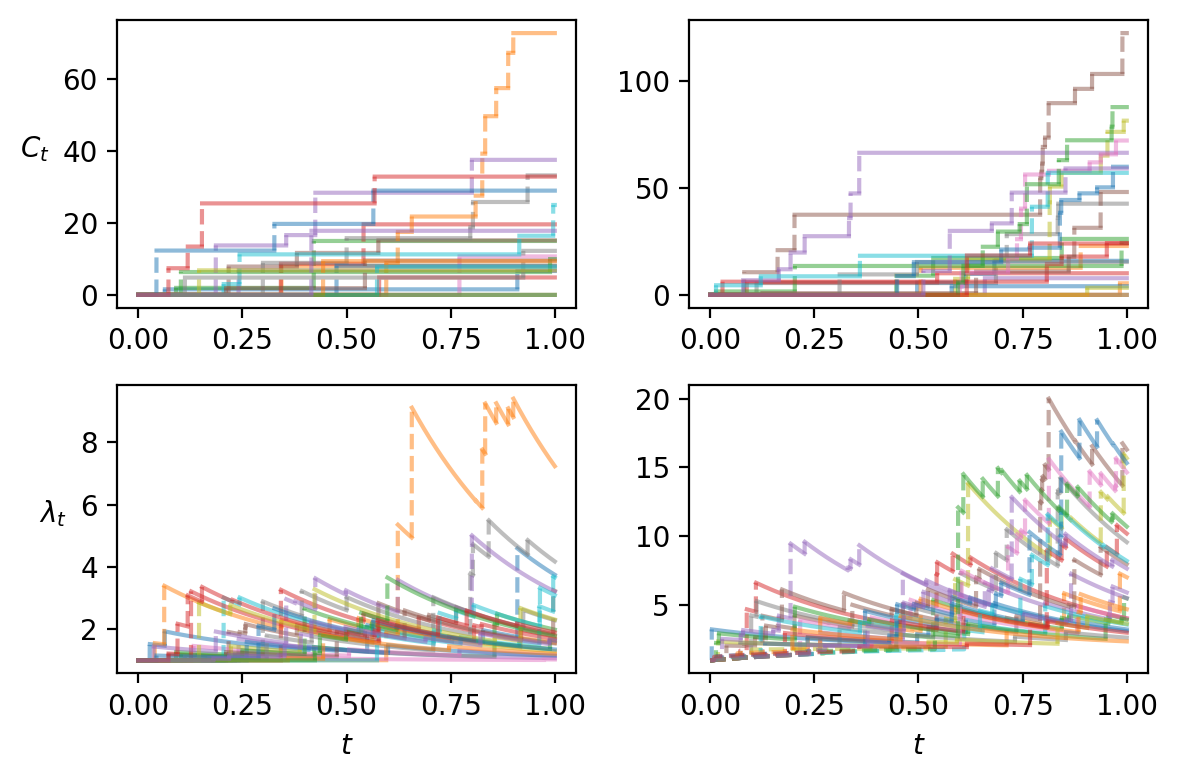

In [17]:
default_params = (
    alpha,
    beta,
    eta,
    gamma,
    delta,
    rho,
    a,
    theta,
    nu,
    psi,
    g_hat,
    h_hat,
    j_hat,
    mu_G,
    lambda_0,
    time_grid,
    T,
)
plot_p_and_pstar(default_params, 1, 25)
plt.savefig("p_and_pstar.png", dpi=300)

In [18]:
retention_levels = sorted([0, 25, 50, np.mean(cdcps), 75, 100])
stoplosses_p = []
stoplosses_pstar = []
for retention in retention_levels:
    stoploss = np.maximum(0, C_ts - retention)
    stoplosses_p.append(np.mean(stoploss))
    stoploss = np.maximum(0, cdcps - retention)
    stoplosses_pstar.append(np.mean(stoploss))

# Make a dataframe with retention levels and expected stop loss
df = pd.DataFrame(
    {
        "Retention": retention_levels,
        "Stop Loss (P)": stoplosses_p,
        "Stop Loss (P*)": stoplosses_pstar,
    }
)

# Change the retention level to a string with 2 decimal places
df["Retention"] = df["Retention"].apply(lambda x: f"{x:.2f}")

print(df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
Retention & Stop Loss (P) & Stop Loss (P*) \\
\midrule
0.00 & 14.041136 & 38.157970 \\
25.00 & 2.632637 & 19.159706 \\
38.16 & 1.014987 & 12.897974 \\
50.00 & 0.424692 & 8.985830 \\
75.00 & 0.070956 & 4.116259 \\
100.00 & 0.007726 & 1.859711 \\
\bottomrule
\end{tabular}



In [19]:
retention = 25

  0%|          | 0/4 [00:00<?, ?it/s]

Loading cached results from cached_samples/sample_0e0812837ce48018b2db68219908d170.npz


 25%|██▌       | 1/4 [00:00<00:01,  1.99it/s]

Loading cached results from cached_samples/sample_31d1b0ff7ff3c453d1b9aa2eec762193.npz


 50%|█████     | 2/4 [00:01<00:01,  1.98it/s]

Loading cached results from cached_samples/sample_cf669b48af2f5bf9b40c1d5933f2bc25.npz


 75%|███████▌  | 3/4 [00:01<00:00,  1.99it/s]

Loading cached results from cached_samples/sample_27db4a1374da3558b897ccb4b303baf2.npz


100%|██████████| 4/4 [00:02<00:00,  1.99it/s]



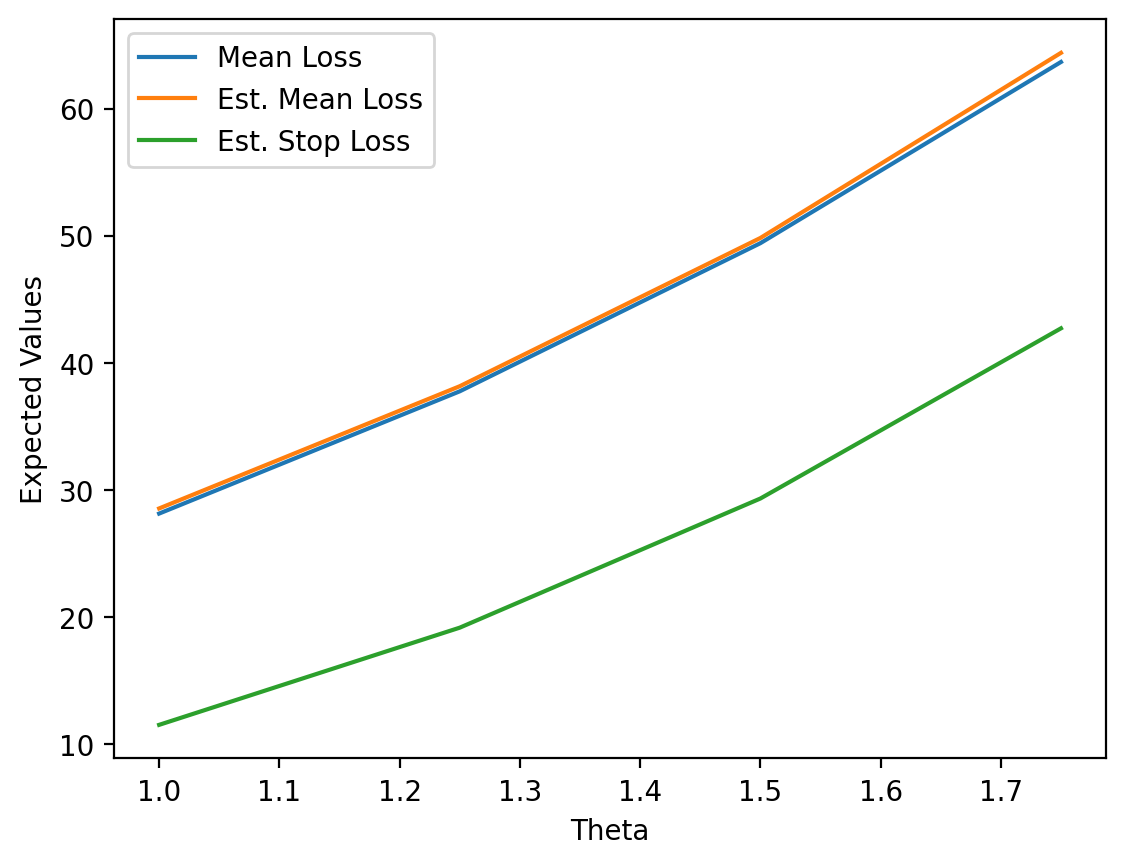

\begin{tabular}{lrll}
\toprule
Theta & Mean Loss & Est. Mean Loss & Est. Stop Loss \\
\midrule
1.00 & 28.137195 & 28.54 ± 0.52 & 11.51 ± 0.41 \\
1.25 & 37.757126 & 38.16 ± 0.68 & 19.16 ± 0.58 \\
1.50 & 49.413007 & 49.82 ± 0.87 & 29.32 ± 0.80 \\
1.75 & 63.671363 & 64.39 ± 1.11 & 42.71 ± 1.05 \\
\bottomrule
\end{tabular}

CPU times: user 2.03 s, sys: 33.3 ms, total: 2.06 s
Wall time: 2.07 s


  0%|          | 0/4 [00:00<?, ?it/s]

Loading cached results from cached_samples/sample_048d8122240f3725dba26d34d9bcd26a.npz


 25%|██▌       | 1/4 [00:00<00:01,  2.02it/s]

Loading cached results from cached_samples/sample_31d1b0ff7ff3c453d1b9aa2eec762193.npz


 50%|█████     | 2/4 [00:00<00:00,  2.01it/s]

Loading cached results from cached_samples/sample_4bff4ae7a48a29e98b22b7a1a1025c2a.npz


 75%|███████▌  | 3/4 [00:01<00:00,  2.00it/s]

Loading cached results from cached_samples/sample_1e2895bf5f1e2f51eefb8657cc23dbd1.npz


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]



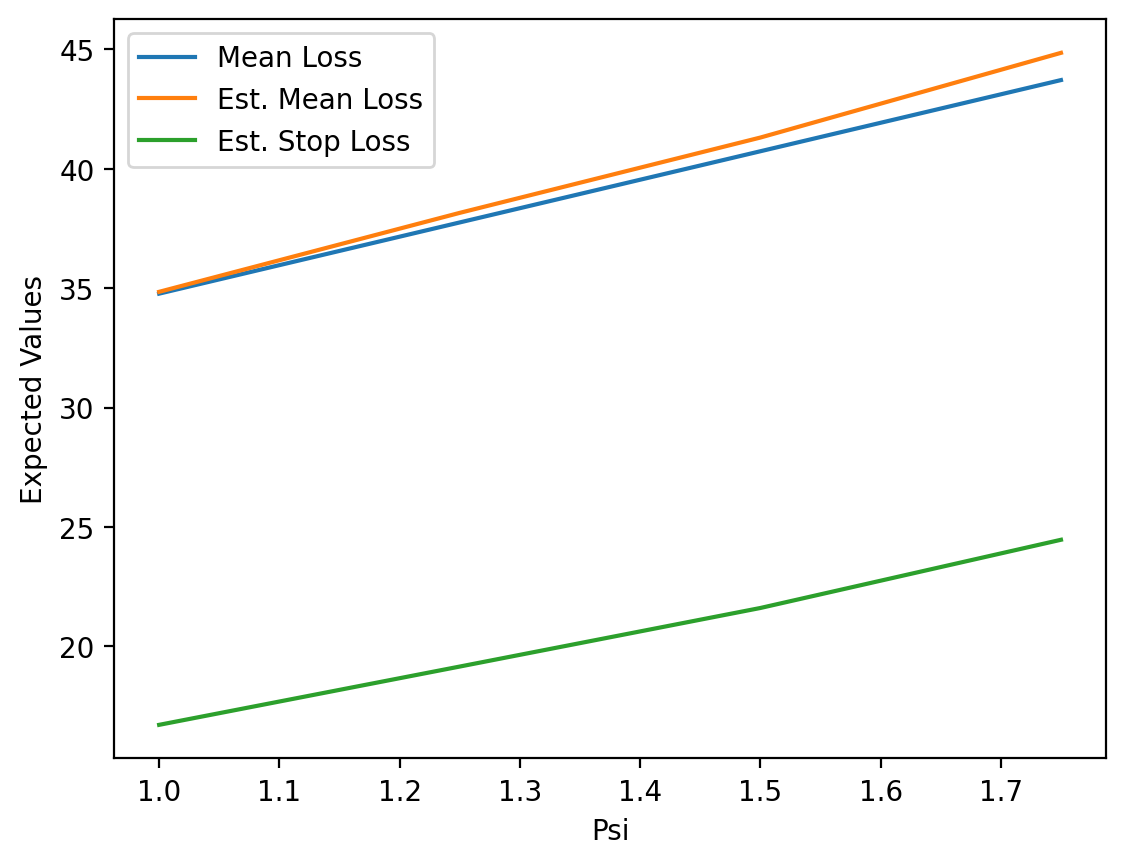

\begin{tabular}{lrll}
\toprule
Psi & Mean Loss & Est. Mean Loss & Est. Stop Loss \\
\midrule
1.00 & 34.775140 & 34.85 ± 0.65 & 16.72 ± 0.55 \\
1.25 & 37.757126 & 38.16 ± 0.68 & 19.16 ± 0.58 \\
1.50 & 40.737259 & 41.31 ± 0.71 & 21.61 ± 0.62 \\
1.75 & 43.718045 & 44.86 ± 0.74 & 24.47 ± 0.66 \\
\bottomrule
\end{tabular}

CPU times: user 2.02 s, sys: 27 ms, total: 2.05 s
Wall time: 2.05 s


  0%|          | 0/4 [00:00<?, ?it/s]

Loading cached results from cached_samples/sample_d5b094261d055401e098d9ab5c7e3c73.npz


 25%|██▌       | 1/4 [00:00<00:01,  1.98it/s]

Loading cached results from cached_samples/sample_31d1b0ff7ff3c453d1b9aa2eec762193.npz


 50%|█████     | 2/4 [00:01<00:01,  1.99it/s]

Loading cached results from cached_samples/sample_319855c5d7ebb2cad93eaaa8bbb4e935.npz


 75%|███████▌  | 3/4 [00:01<00:00,  1.95it/s]

Loading cached results from cached_samples/sample_3b67e37b90368b4b7b47cf0dace38d74.npz


100%|██████████| 4/4 [00:02<00:00,  1.95it/s]



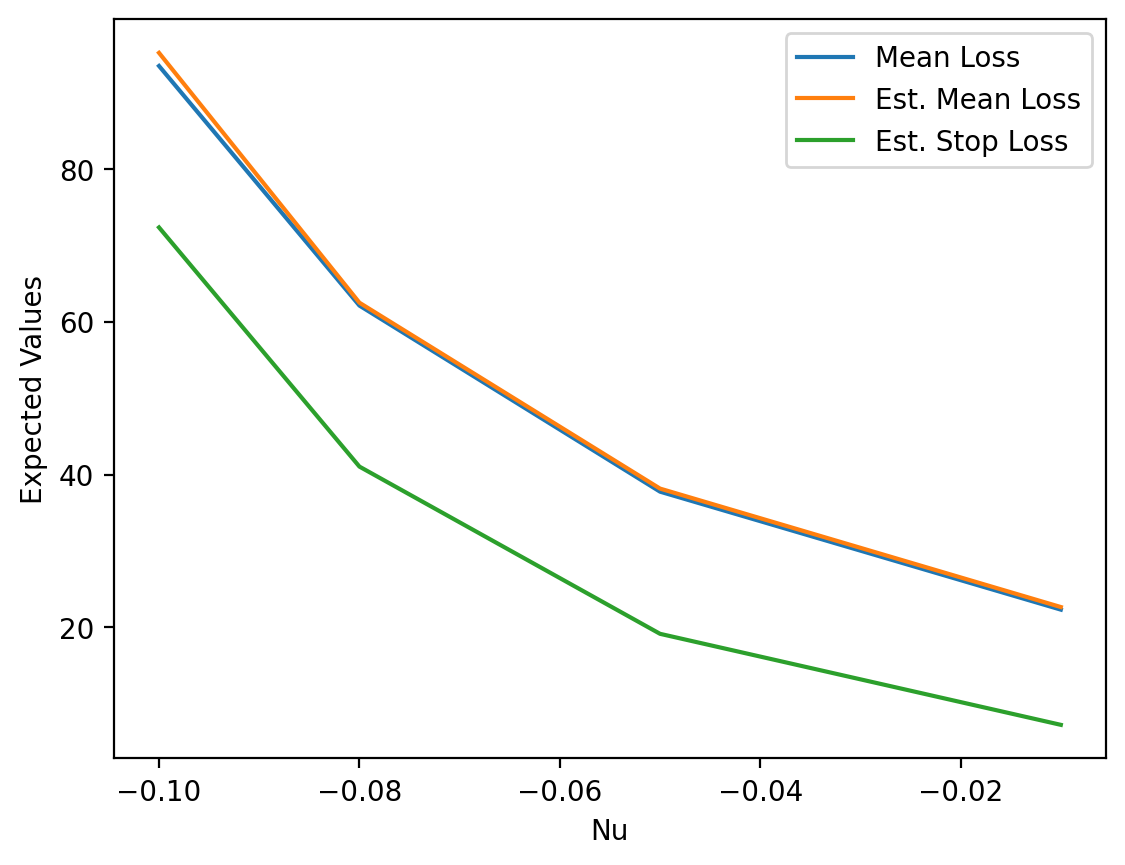

\begin{tabular}{lrll}
\toprule
Nu & Mean Loss & Est. Mean Loss & Est. Stop Loss \\
\midrule
-0.01 & 22.322487 & 22.66 ± 0.42 & 7.25 ± 0.30 \\
-0.05 & 37.757126 & 38.16 ± 0.68 & 19.16 ± 0.58 \\
-0.08 & 62.101734 & 62.48 ± 1.08 & 41.04 ± 1.02 \\
-0.10 & 93.448189 & 95.16 ± 1.67 & 72.32 ± 1.62 \\
\bottomrule
\end{tabular}

CPU times: user 2.03 s, sys: 57.7 ms, total: 2.09 s
Wall time: 2.11 s


In [20]:
# Run computations for different varying parameters
default_params = (alpha, beta, eta, gamma, delta, rho, a, theta, nu, psi,
            g_hat, h_hat, j_hat, mu_G, lambda_0, time_grid, T)
%time compute_statistics([1.0, 1.25, 1.5, 1.75], 'Theta', default_params, retention)
%time compute_statistics([1.0, 1.25, 1.5, 1.75], 'Psi', default_params, retention)
%time compute_statistics([-0.01, -0.05, -0.08, -0.1], 'Nu', default_params, retention)

# Process Comparison: DCP, Hawkes, and Cox

We now compare three process variations using the same DCP framework with different parameter settings:
- **Dynamic Contagion Process (DCP)**: Full model (a=1, ρ=4)  
- **Hawkes Process**: No external jumps (a=1, ρ=0)
- **Cox Process**: No self-excitation (a=0, ρ=4)

This comparison shows how different components contribute to stop-loss reinsurance pricing.

In [21]:
# Define process variations by parameter settings
processes = {
    'DCP': {'name': 'Dynamic Contagion Process', 'a': a, 'rho': rho, 'beta': beta},
    'Hawkes': {'name': 'Hawkes Process', 'a': a, 'rho': 0.0, 'beta': beta},  # No external jumps
    'Cox': {'name': 'Cox Process', 'a': 0.0, 'rho': rho, 'beta': np.inf}     # No self-excitation (infinite beta makes self-jumps = 0)
}

# Use the same retention levels as before
comparison_retention_levels = [0, 25, 38.15, 50, 75, 100]

print("Process configurations:")
for key, process in processes.items():
    print(f"  {key}: a = {process['a']}, ρ = {process['rho']}, β = {process['beta']}")
print(f"Retention levels: {comparison_retention_levels}")

Process configurations:
  DCP: a = 1, ρ = 4, β = 1.0
  Hawkes: a = 1, ρ = 0.0, β = 1.0
  Cox: a = 0.0, ρ = 4, β = inf
Retention levels: [0, 25, 38.15, 50, 75, 100]


In [22]:
def simulate_process_original_measure(a_val, rho_val, beta_val, num_sims=10_000, seed=2025):
    """Simulate a process under the original measure P."""
    rg = rnd.default_rng(seed)
    
    # Create beta-specific self-jump distribution function
    def process_self_jump_size_dist(rg):
        if np.isinf(beta_val):
            return 0.0  # No self-excitation for Cox process
        else:
            return rg.exponential(scale=1 / beta_val)
    
    C_ts = np.zeros(num_sims)
    
    for i in tqdm(range(num_sims), desc=f"Original (a={a_val}, ρ={rho_val}, β={beta_val})"):
        count, T1, X, T2, Y = simulate_dynamic_contagion_thinning(
            rg, T, lambda_0, a_val, rho_val, delta, process_self_jump_size_dist, ext_jump_size_dist
        )
        losses = catastrophe_loss_dist(rg, count)
        C_ts[i] = np.sum(losses)
    
    return C_ts

def simulate_process_esscher_measure(a_val, rho_val, beta_val, num_sims=10_000, seed=2025):
    """Simulate a process under the Esscher measure P*."""

    mu_G = 1 / beta_val
    def g_hat(s):
        return 1 / (1 + s / beta_val)
    g_hat_prime = lambda s: -1 / (beta_val * (1 + s / beta_val) ** 2)
    
    # Generate tilted parameters for this process configuration
    # The modified tilted_parameters function now handles beta=inf correctly
    tilted_params = tilted_parameters(
        alpha, beta_val, eta, gamma, delta, rho_val, a_val, theta, nu, psi,
        g_hat, g_hat_prime, h_hat, h_hat_prime, j_hat, mu_G, lambda_0, time_grid, T
    )
    
    rg = np.random.default_rng(seed)
    seeds = rg.integers(0, 2**32, size=num_sims)
    
    C_ts = np.zeros(num_sims)
    
    for i in tqdm(range(num_sims), desc=f"Esscher (a={a_val}, ρ={rho_val}, β={beta_val})"):
        # Use the standard tilted sampling - the tilted_parameters function now handles Cox case internally
        _, _, _, _, _, C_T = sample_tilted_cdcp(seeds[i], tilted_params, time_grid, T)
        C_ts[i] = C_T
    
    return C_ts


Simulating Dynamic Contagion Process
Under original measure P:


Original (a=1, ρ=4, β=1.0): 100%|██████████| 10000/10000 [00:00<00:00, 13176.10it/s]


Under Esscher measure P*:


Esscher (a=1, ρ=4, β=1.0): 100%|██████████| 10000/10000 [09:33<00:00, 17.44it/s]


Original measure: E[C_T] = 14.040
Esscher measure: E[C_T] = 38.158

Simulating Hawkes Process
Under original measure P:


Original (a=1, ρ=0.0, β=1.0): 100%|██████████| 10000/10000 [00:00<00:00, 17439.56it/s]


Under Esscher measure P*:


Esscher (a=1, ρ=0.0, β=1.0): 100%|██████████| 10000/10000 [02:50<00:00, 58.80it/s]


Original measure: E[C_T] = 9.694
Esscher measure: E[C_T] = 22.852

Simulating Cox Process
Under original measure P:


Original (a=0.0, ρ=4, β=inf): 100%|██████████| 10000/10000 [00:01<00:00, 8965.52it/s]



Under Esscher measure P*:


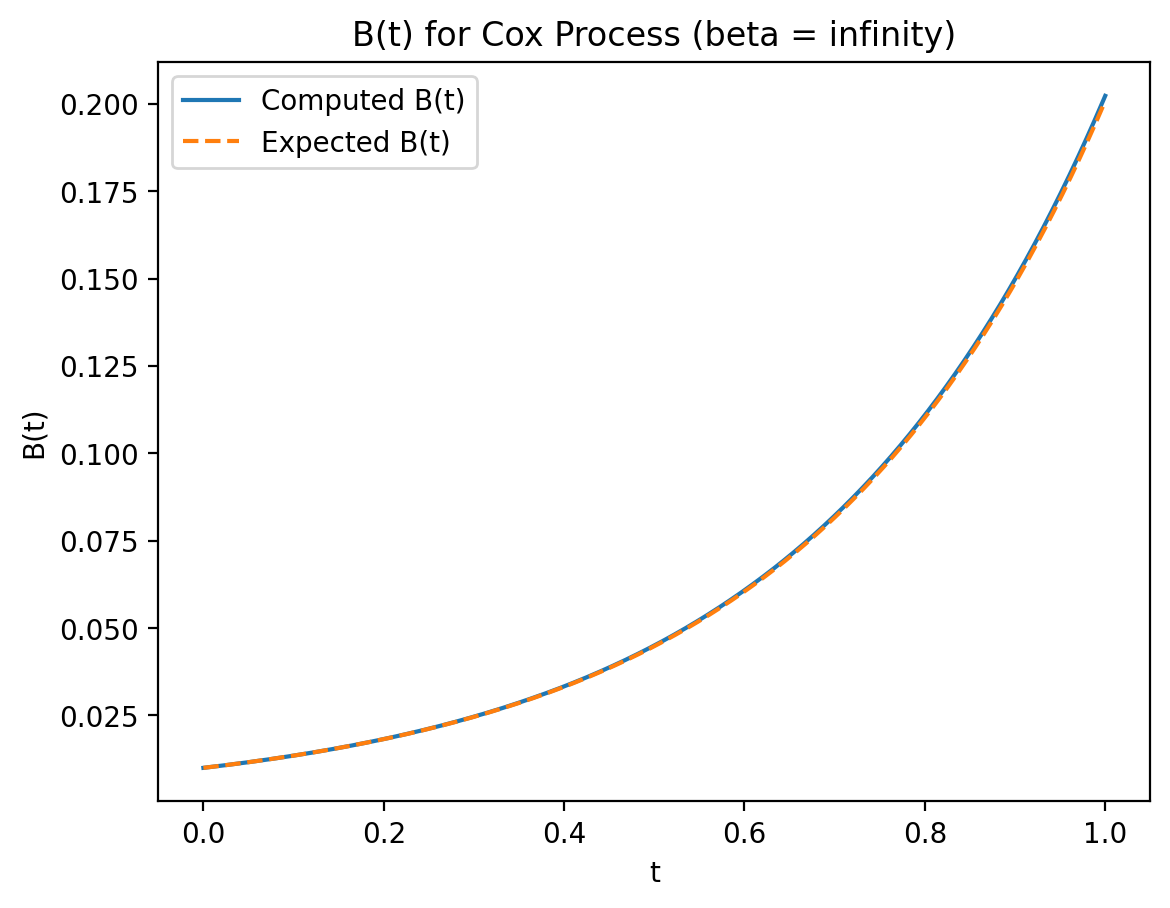

Esscher (a=0.0, ρ=4, β=inf): 100%|██████████| 10000/10000 [09:42<00:00, 17.16it/s]

Original measure: E[C_T] = 5.815
Esscher measure: E[C_T] = 12.488

All process simulations completed!


In [23]:
# Run simulations for all processes under both measures
comparison_results = {}

for process_key, process_config in processes.items():
    print(f"\n{'='*50}")
    print(f"Simulating {process_config['name']}")
    print(f"{'='*50}")
    
    a_val = process_config['a']
    rho_val = process_config['rho']
    beta_val = process_config['beta']
    
    # Original measure
    print("Under original measure P:")
    C_ts_original = simulate_process_original_measure(a_val, rho_val, beta_val, 10_000, 2025)
    
    # Esscher measure  
    print("Under Esscher measure P*:")
    C_ts_esscher = simulate_process_esscher_measure(a_val, rho_val, beta_val, 10_000, 2025)
    
    comparison_results[process_key] = {
        'name': process_config['name'],
        'original': C_ts_original,
        'esscher': C_ts_esscher
    }
    
    print(f"Original measure: E[C_T] = {np.mean(C_ts_original):.3f}")
    print(f"Esscher measure: E[C_T] = {np.mean(C_ts_esscher):.3f}")

print(f"\n{'='*50}")
print("All process simulations completed!")
print(f"{'='*50}")

In [24]:
# Calculate stop-loss estimates for all processes
def calculate_stop_loss_estimates(C_ts, retention_levels):
    """Calculate stop-loss estimates for given retention levels."""
    estimates = []
    for L in retention_levels:
        stop_loss = np.maximum(0, C_ts - L)
        mean_estimate = np.mean(stop_loss)
        std_error = np.std(stop_loss) / np.sqrt(len(stop_loss))
        ci_95 = 1.96 * std_error
        estimates.append({
            'retention': L,
            'mean': mean_estimate,
            'std_error': std_error,
            'ci_95': ci_95,
            'formatted': f"{mean_estimate:.2f} ± {ci_95:.2f}"
        })
    return estimates

# Calculate stop-loss estimates for all processes and measures
process_stop_loss_results = {}

for process_key, result in comparison_results.items():
    print(f"\nStop-loss analysis for {result['name']}:")
    print("-" * 60)
    
    # Original measure
    original_stop_loss = calculate_stop_loss_estimates(result['original'], comparison_retention_levels)
    
    # Esscher measure
    esscher_stop_loss = calculate_stop_loss_estimates(result['esscher'], comparison_retention_levels)
    
    process_stop_loss_results[process_key] = {
        'name': result['name'],
        'original': original_stop_loss,
        'esscher': esscher_stop_loss
    }
    
    # Display results
    print(f"{'Retention':<10} {'Original (P)':<20} {'Esscher (P*)':<20}")
    print("-" * 60)
    for i, L in enumerate(comparison_retention_levels):
        orig_est = original_stop_loss[i]['formatted']
        ess_est = esscher_stop_loss[i]['formatted']
        print(f"{L:<10.2f} {orig_est:<20} {ess_est:<20}")


Stop-loss analysis for Dynamic Contagion Process:
------------------------------------------------------------
Retention  Original (P)         Esscher (P*)        
------------------------------------------------------------
0.00       14.04 ± 0.29         38.16 ± 0.68        
25.00      2.63 ± 0.16          19.16 ± 0.58        
38.15      1.02 ± 0.10          12.90 ± 0.51        
50.00      0.42 ± 0.07          8.99 ± 0.44         
75.00      0.07 ± 0.03          4.12 ± 0.31         
100.00     0.01 ± 0.01          1.86 ± 0.22         

Stop-loss analysis for Hawkes Process:
------------------------------------------------------------
Retention  Original (P)         Esscher (P*)        
------------------------------------------------------------
0.00       9.69 ± 0.24          22.85 ± 0.51        
25.00      1.29 ± 0.11          8.52 ± 0.39         
38.15      0.46 ± 0.06          5.16 ± 0.32         
50.00      0.17 ± 0.04          3.33 ± 0.26         
75.00      0.02 ± 0.01       

In [25]:
# Create individual LaTeX tables for each process
def create_individual_process_table(process_key, table_number):
    """Create a LaTeX table for a specific process."""
    
    process_name = process_stop_loss_results[process_key]['name']
    
    # Create table data
    data = []
    for i, L in enumerate(comparison_retention_levels):
        orig_result = process_stop_loss_results[process_key]['original'][i]
        ess_result = process_stop_loss_results[process_key]['esscher'][i]
        
        data.append({
            'L': f"{L:.2f}",
            'Original': f"{orig_result['mean']:.6f}",
            'Esscher': f"{ess_result['mean']:.6f}"
        })
    
    df = pd.DataFrame(data)
    
    # Generate LaTeX with custom formatting
    latex_table = df.to_latex(
        index=False,
        column_format='rrr',
        escape=False,
        float_format="%.6f"
    )
    
    # Add proper LaTeX table environment and formatting
    table_labels = {
        'DCP': ('Dynamic Contagion Process', '4'),
        'Hawkes': ('Generalized Hawkes case', '5'), 
        'Cox': ('Cox case', '6')
    }
    
    table_title, label_num = table_labels[process_key]
    
    # Replace the basic tabular with enhanced formatting
    enhanced_table = f"""\\begin{{table}}[H] 
\\centering
    \\begin{{tabular}}{{rrr}}
    \\toprule
    $L$ & $\\widehat{{\\mathbb{{E}}}}[(C_t - L)^+]$ & $\\widehat{{\\tilde{{\\mathbb{{E}}}}}}[(C_t - L)^+]$ \\\\
    \\midrule"""
    
    # Add data rows
    for _, row in df.iterrows():
        enhanced_table += f"\n    {row['L']} & {row['Original']} & {row['Esscher']} \\\\"
    
    enhanced_table += f"""
    \\bottomrule
    \\end{{tabular}}
    \\caption{{The stop loss CMC estimates  $\\widehat{{\\mathbb{{E}}}}[(C_t - L)^+]$ under the original measure and  $\\widehat{{\\tilde{{\\mathbb{{E}}}}}}[(C_t - L)^+]$ under the Esscher measure for different $L$ retention levels ({table_title}).}}
    \\label{{Table {label_num}}}
\\end{{table}}"""
    
    return enhanced_table

# Create comprehensive comparison table (existing functionality)
def create_process_comparison_table():
    """Create a summary table comparing all processes and measures."""
    
    data = []
    
    for process_key in ['DCP', 'Hawkes', 'Cox']:
        process_name = process_stop_loss_results[process_key]['name']
        
        for i, L in enumerate(comparison_retention_levels):
            orig_result = process_stop_loss_results[process_key]['original'][i]
            ess_result = process_stop_loss_results[process_key]['esscher'][i]
            
            data.append({
                'Process': process_name,
                'Retention': f"{L:.2f}",
                'Stop-Loss (P)': orig_result['formatted'],
                'Stop-Loss (P*)': ess_result['formatted']
            })
    
    return pd.DataFrame(data)

comparison_summary_df = create_process_comparison_table()

print("PROCESS COMPARISON: STOP-LOSS ESTIMATES")
print("=" * 80)
print(comparison_summary_df.to_string(index=False))

# Create individual LaTeX tables for each process
print("\n\nIndividual LaTeX Tables:")
print("=" * 50)

for process_key in ['DCP', 'Hawkes', 'Cox']:
    process_name = process_stop_loss_results[process_key]['name']
    print(f"\n{process_name}:")
    print("-" * 40)
    table_latex = create_individual_process_table(process_key, process_key)
    print(table_latex)

# Create comprehensive comparison LaTeX table (existing functionality)
print("\n\nCombined LaTeX Table:")
print("=" * 40)
print(comparison_summary_df.to_latex(index=False))

PROCESS COMPARISON: STOP-LOSS ESTIMATES
                  Process Retention Stop-Loss (P) Stop-Loss (P*)
Dynamic Contagion Process      0.00  14.04 ± 0.29   38.16 ± 0.68
Dynamic Contagion Process     25.00   2.63 ± 0.16   19.16 ± 0.58
Dynamic Contagion Process     38.15   1.02 ± 0.10   12.90 ± 0.51
Dynamic Contagion Process     50.00   0.42 ± 0.07    8.99 ± 0.44
Dynamic Contagion Process     75.00   0.07 ± 0.03    4.12 ± 0.31
Dynamic Contagion Process    100.00   0.01 ± 0.01    1.86 ± 0.22
           Hawkes Process      0.00   9.69 ± 0.24   22.85 ± 0.51
           Hawkes Process     25.00   1.29 ± 0.11    8.52 ± 0.39
           Hawkes Process     38.15   0.46 ± 0.06    5.16 ± 0.32
           Hawkes Process     50.00   0.17 ± 0.04    3.33 ± 0.26
           Hawkes Process     75.00   0.02 ± 0.01    1.36 ± 0.17
           Hawkes Process    100.00   0.00 ± 0.00    0.56 ± 0.12
              Cox Process      0.00   5.81 ± 0.16   12.49 ± 0.27
              Cox Process     25.00   0.22 ± 0.03 

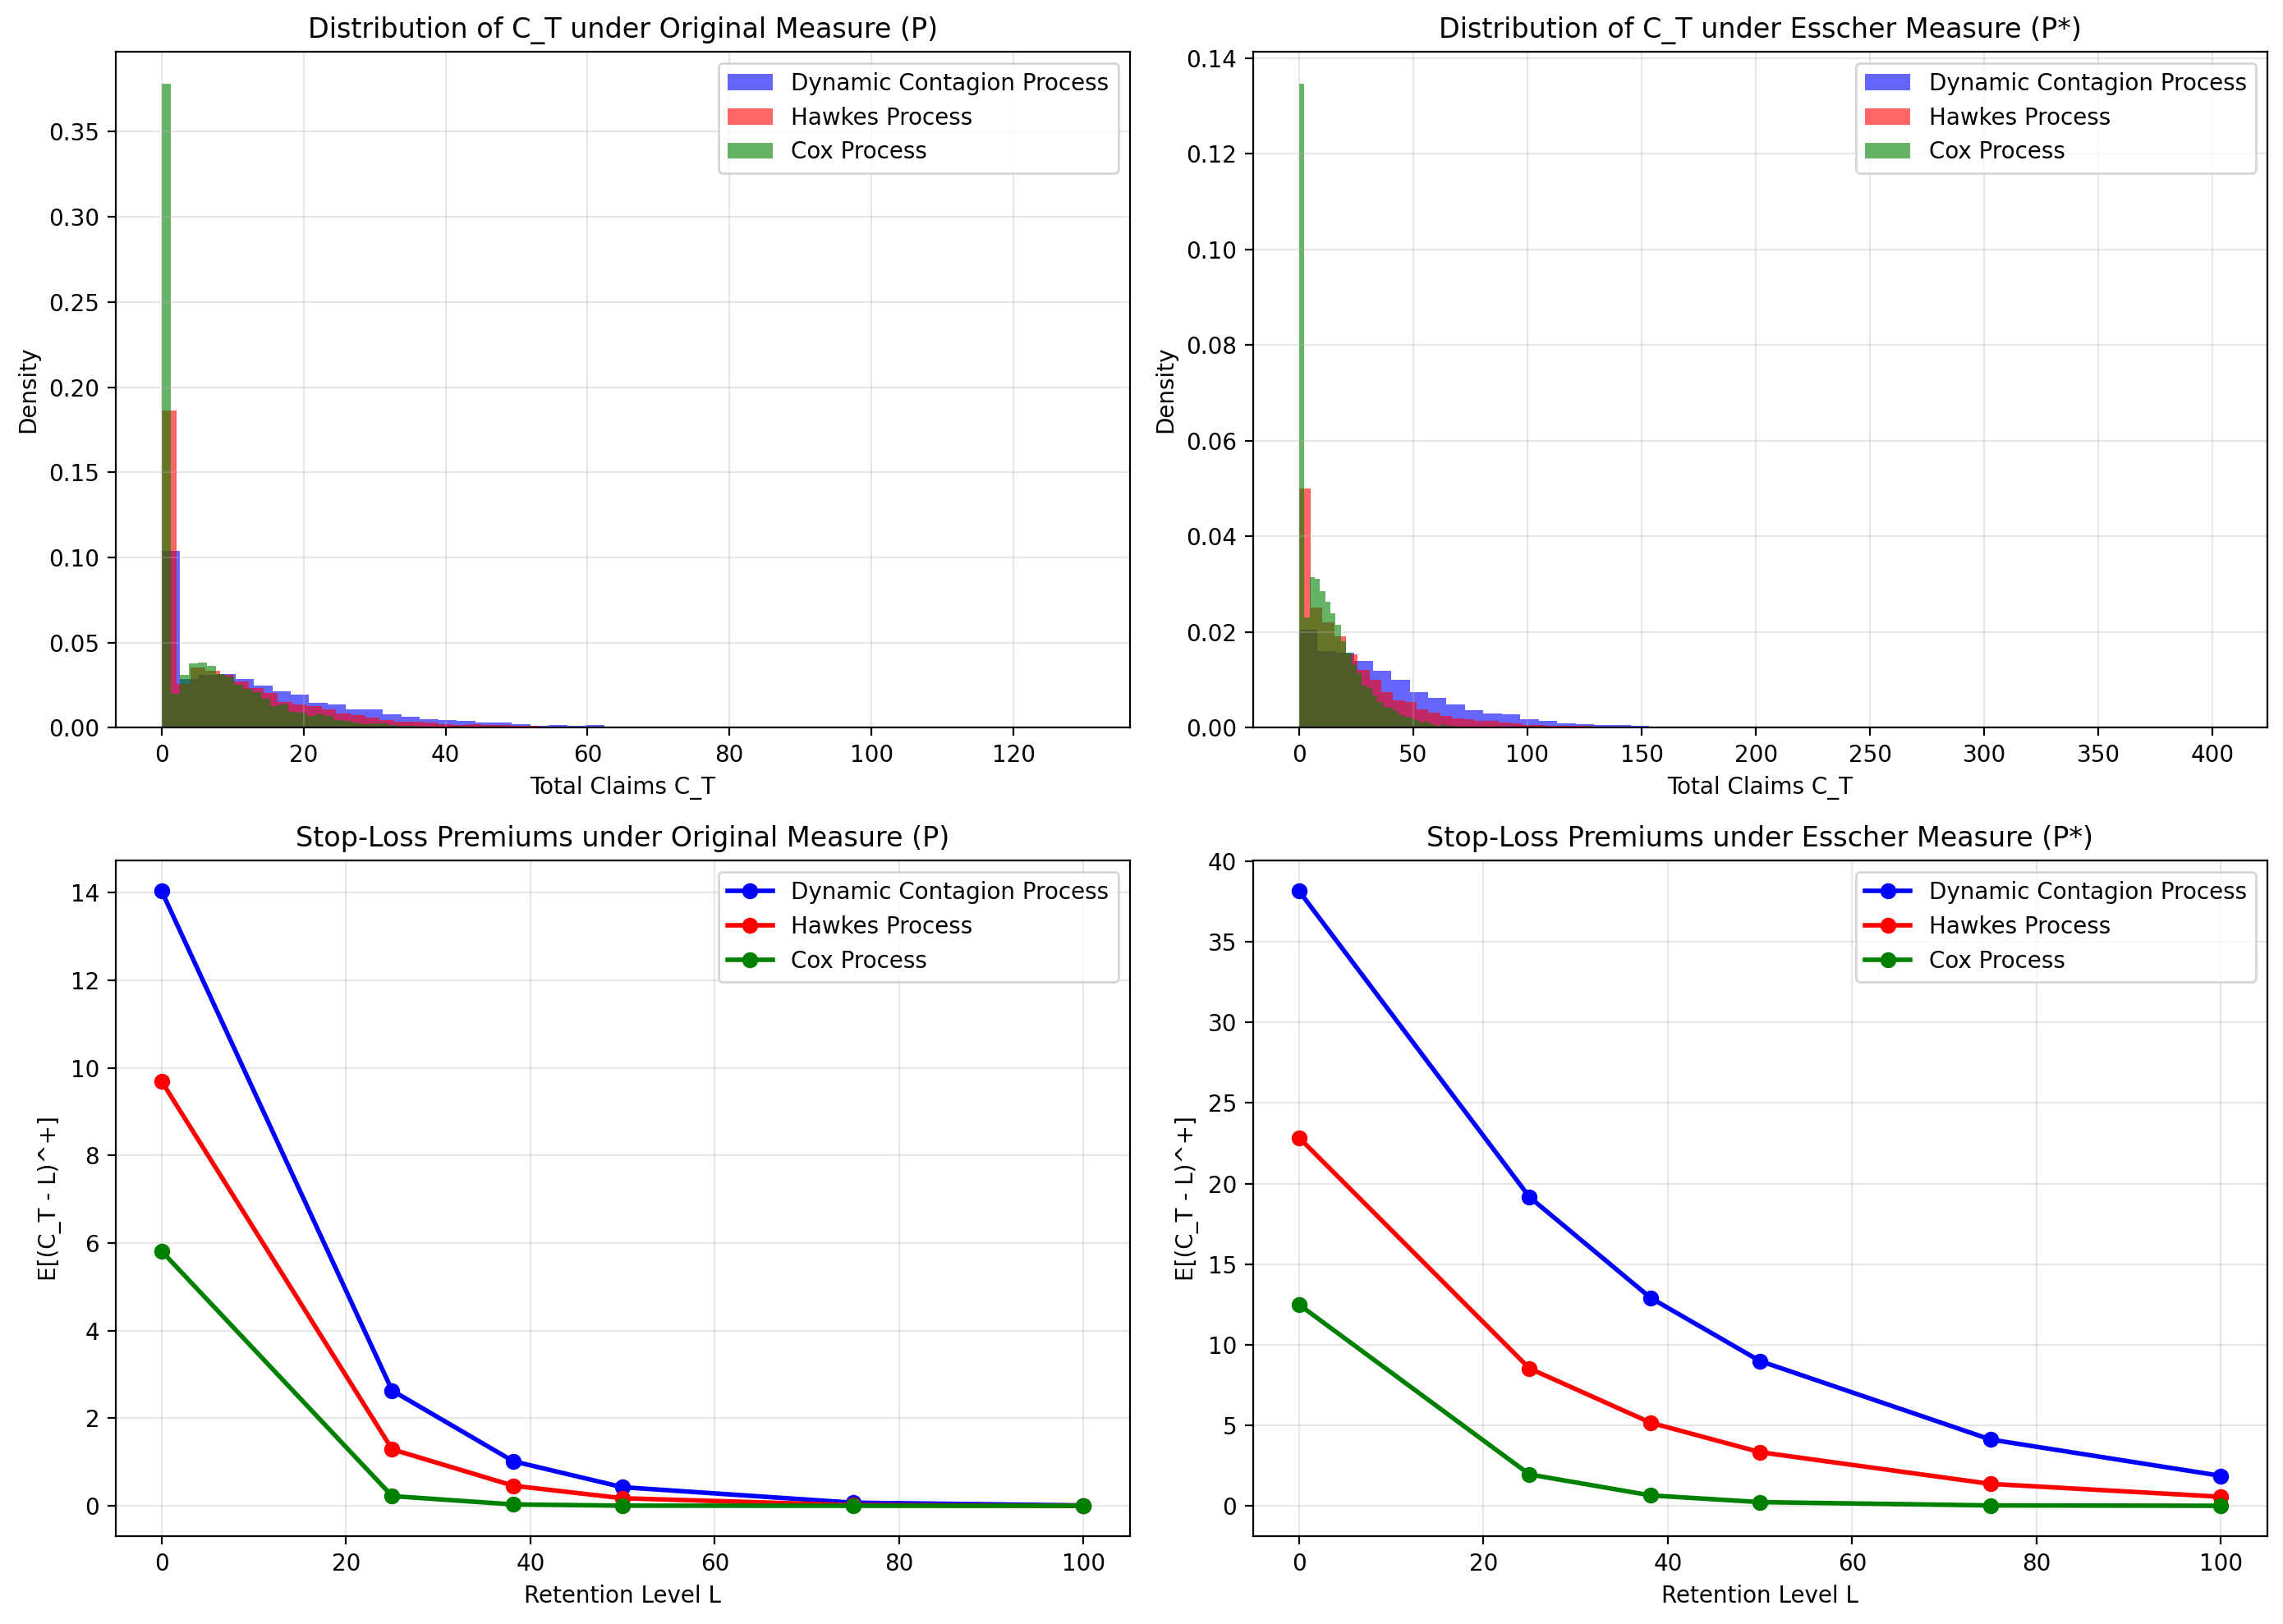


Process Comparison Summary:
Dynamic Contagion Process:
  E[C_T] under P:  14.040
  E[C_T] under P*: 38.158
  Ratio (P*/P):    2.718

Hawkes Process:
  E[C_T] under P:  9.694
  E[C_T] under P*: 22.852
  Ratio (P*/P):    2.357

Cox Process:
  E[C_T] under P:  5.815
  E[C_T] under P*: 12.488
  Ratio (P*/P):    2.148



In [26]:
# Visualization comparing the three processes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution comparison (Original measure)
ax1 = axes[0, 0]
colors = ['blue', 'red', 'green']
for i, process_key in enumerate(['DCP', 'Hawkes', 'Cox']):
    C_ts = comparison_results[process_key]['original']
    ax1.hist(C_ts, bins=50, alpha=0.6, label=process_stop_loss_results[process_key]['name'], 
             color=colors[i], density=True)
ax1.set_xlabel('Total Claims C_T')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of C_T under Original Measure (P)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribution comparison (Esscher measure)
ax2 = axes[0, 1]
for i, process_key in enumerate(['DCP', 'Hawkes', 'Cox']):
    C_ts = comparison_results[process_key]['esscher']
    ax2.hist(C_ts, bins=50, alpha=0.6, label=process_stop_loss_results[process_key]['name'], 
             color=colors[i], density=True)
ax2.set_xlabel('Total Claims C_T')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of C_T under Esscher Measure (P*)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Stop-loss premiums vs retention (Original measure)
ax3 = axes[1, 0]
for i, process_key in enumerate(['DCP', 'Hawkes', 'Cox']):
    means = [est['mean'] for est in process_stop_loss_results[process_key]['original']]
    ax3.plot(comparison_retention_levels, means, 'o-', 
             label=process_stop_loss_results[process_key]['name'], 
             color=colors[i], linewidth=2, markersize=6)
ax3.set_xlabel('Retention Level L')
ax3.set_ylabel('E[(C_T - L)^+]')
ax3.set_title('Stop-Loss Premiums under Original Measure (P)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Stop-loss premiums vs retention (Esscher measure)
ax4 = axes[1, 1]
for i, process_key in enumerate(['DCP', 'Hawkes', 'Cox']):
    means = [est['mean'] for est in process_stop_loss_results[process_key]['esscher']]
    ax4.plot(comparison_retention_levels, means, 'o-', 
             label=process_stop_loss_results[process_key]['name'], 
             color=colors[i], linewidth=2, markersize=6)
ax4.set_xlabel('Retention Level L')
ax4.set_ylabel('E[(C_T - L)^+]')
ax4.set_title('Stop-Loss Premiums under Esscher Measure (P*)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nProcess Comparison Summary:")
print("=" * 60)
for process_key in ['DCP', 'Hawkes', 'Cox']:
    name = process_stop_loss_results[process_key]['name']
    orig_mean = np.mean(comparison_results[process_key]['original'])
    ess_mean = np.mean(comparison_results[process_key]['esscher'])
    print(f"{name}:")
    print(f"  E[C_T] under P:  {orig_mean:.3f}")
    print(f"  E[C_T] under P*: {ess_mean:.3f}")
    print(f"  Ratio (P*/P):    {ess_mean/orig_mean:.3f}")
    print()